In [1]:
!pip install -r requirements.txt

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/e8/fb/e5955e2ddbdf2baee461eb53ec8d0adedd20a6dfc5510ef8d5e7e44ba461/scipy-1.13.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 1.1 MB/s eta 0:00:00a 0:00:01
  Obtaining dependency information for tensorflow-addons from https://files.pythonhosted.org/packages/24/94/80165946ec4986505cbfac29b5ae79544bfe2200d9d7883e1ad7c7342a55/tensorflow_addons-0.23.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
  Obtaining dependency information for tensorflow-model-optimization from https://files.pythonhosted.org/packages/5a/a0/f38c9ce977285d3f347f6d64cf227924fe9fc97d780d6df4a55563e311af/tensorflow_model_optimization-0.8.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for pandas from https://files.pythonhosted.org/packages/d4/47/1ccf9f62d2674d3ca3e95452c5f9dd114234d1535dec77c96528bf6a31fc/pandas

In [2]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow.keras import layers, models

import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

2024-04-09 13:40:42.107859: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-09 13:40:42.138416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 13:40:42.138433: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 13:40:42.138457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-09 13:40:42.143737: I tensorflow/core/platform/cpu_feature_g

In [3]:
IMAGE_SIZE = 128
BATCH_SIZE = 32

In [4]:
def load_dataset():
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        "train",
        shuffle=True,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )
    return dataset

# Load the dataset
dataset = load_dataset()

# Extract class names and verify
class_names = dataset.class_names
print("Class names:", class_names)

Found 70295 files belonging to 38 classes.


2024-04-09 13:41:04.284230: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20585 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4090, pci bus id: 0000:01:00.0, compute capability: 8.9
2024-04-09 13:41:04.620949: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Class names: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomat

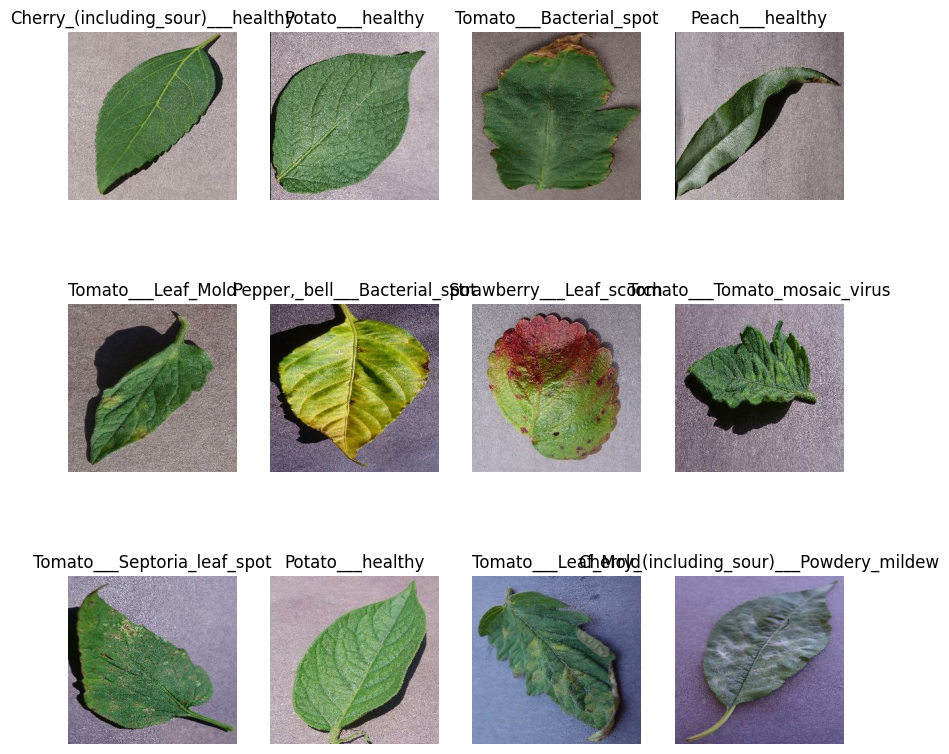

Labels: [29 15  5 25 35 18 31 22 17 11 25 30 19 20 36  9 30  8 17 18 19 31 37  0
 20 15  6 34 31 27 26 27]


In [5]:
# Function to visualize dataset samples
def visualize_dataset(dataset):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
        for i in range(12):
            ax = plt.subplot(3, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")
    plt.show()

# Visualize a few samples from the dataset
visualize_dataset(dataset)

# Function to verify label extraction
def verify_labels(dataset):
    for images, labels in dataset.take(1):
        print("Labels:", labels.numpy())

# Verify label extraction
verify_labels(dataset)

In [ ]:
40-30-30
50-25-25
60-20-20
70-15-15
80-10-10

In [44]:
# Split the dataset into train, validation, and test sets
train_ds40 = dataset.take(int(0.4 * len(dataset)))
val_ds40 = dataset.skip(int(0.4 * len(dataset))).take(int(0.3 * len(dataset)))
test_ds40 = dataset.skip(int(0.4 * len(dataset))).skip(int(0.3 * len(dataset)))

# Prepare the datasets for training
train_ds40 = train_ds40.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds40 = val_ds40.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds40 = test_ds40.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Split the dataset into train, validation, and test sets
train_ds50 = dataset.take(int(0.5 * len(dataset)))
val_ds50 = dataset.skip(int(0.5 * len(dataset))).take(int(0.25 * len(dataset)))
test_ds50 = dataset.skip(int(0.5 * len(dataset))).skip(int(0.25 * len(dataset)))

# Prepare the datasets for training
train_ds50 = train_ds50.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds50 = val_ds50.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds50 = test_ds50.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [26]:
# Split the dataset into train, validation, and test sets
train_ds60 = dataset.take(int(0.6 * len(dataset)))
val_ds60 = dataset.skip(int(0.6 * len(dataset))).take(int(0.2 * len(dataset)))
test_ds60 = dataset.skip(int(0.6 * len(dataset))).skip(int(0.2 * len(dataset)))

# Prepare the datasets for training
train_ds40 = train_ds60.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds40 = val_ds60.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds40 = test_ds60.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
# Split the dataset into train, validation, and test sets
train_ds70 = dataset.take(int(0.7 * len(dataset)))
val_ds70 = dataset.skip(int(0.7 * len(dataset))).take(int(0.15 * len(dataset)))
test_ds70 = dataset.skip(int(0.7 * len(dataset))).skip(int(0.15 * len(dataset)))

# Prepare the datasets for training
train_ds70 = train_ds70.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds70 = val_ds70.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds70 = test_ds70.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [6]:
# Split the dataset into train, validation, and test sets
train_ds80 = dataset.take(int(0.8 * len(dataset)))
val_ds80 = dataset.skip(int(0.8 * len(dataset))).take(int(0.1 * len(dataset)))
test_ds80 = dataset.skip(int(0.8 * len(dataset))).skip(int(0.1 * len(dataset)))

# Prepare the datasets for training
train_ds80 = train_ds80.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds80 = val_ds80.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds80 = test_ds80.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
model_dep = tf.keras.models.Sequential()

model_dep.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',input_shape=[128,128,3]))
model_dep.add(tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu'))
model_dep.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))  

model_dep.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu'))
model_dep.add(tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'))
model_dep.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model_dep.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu'))
model_dep.add(tf.keras.layers.Conv2D(filters=128,kernel_size=3,activation='relu'))
model_dep.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model_dep.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu'))
model_dep.add(tf.keras.layers.Conv2D(filters=256,kernel_size=3,activation='relu'))
model_dep.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model_dep.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,padding='same',activation='relu'))
model_dep.add(tf.keras.layers.Conv2D(filters=512,kernel_size=3,activation='relu'))
model_dep.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))

model_dep.add(tf.keras.layers.Dropout(0.25))
model_dep.add(tf.keras.layers.Flatten())
model_dep.add(tf.keras.layers.Dense(units=1500,activation='relu'))

model_dep.add(tf.keras.layers.Dropout(0.5)) #To avoid overfitting

#Output Layer
model_dep.add(tf.keras.layers.Dense(units=38,activation='softmax'))


model_dep.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss="sparse_categorical_crossentropy",metrics=['accuracy'])
model_dep.summary()

Model: "sequential_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_124 (Conv2D)         (None, 128, 128, 32)      896       
                                                                 
 conv2d_125 (Conv2D)         (None, 126, 126, 32)      9248      
                                                                 
 max_pooling2d_62 (MaxPooli  (None, 63, 63, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_126 (Conv2D)         (None, 63, 63, 64)        18496     
                                                                 
 conv2d_127 (Conv2D)         (None, 61, 61, 64)        36928     
                                                                 
 max_pooling2d_63 (MaxPooli  (None, 30, 30, 64)        0         
 ng2D)                                               

In [12]:
history_1 = model_dep.fit(
    train_ds40,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds40
)

Epoch 1/20


2024-04-07 15:17:19.149237: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-04-07 15:17:19.803454: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-07 15:17:21.531856: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f938cb890b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-07 15:17:21.531885: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-07 15:17:21.536683: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-07 15:17:21.661718: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


878/878 [==============================] - 57s 47ms/step - loss: 2.8831 - accuracy: 0.1886 - val_loss: 1.6677 - val_accuracy: 0.5032
Epoch 2/20
878/878 [==============================] - 32s 36ms/step - loss: 1.2045 - accuracy: 0.6299 - val_loss: 0.8054 - val_accuracy: 0.7462
Epoch 3/20
878/878 [==============================] - 32s 36ms/step - loss: 0.6896 - accuracy: 0.7863 - val_loss: 0.4837 - val_accuracy: 0.8469
Epoch 4/20
878/878 [==============================] - 32s 36ms/step - loss: 0.4552 - accuracy: 0.8583 - val_loss: 0.4044 - val_accuracy: 0.8683
Epoch 5/20
878/878 [==============================] - 32s 36ms/step - loss: 0.3248 - accuracy: 0.8918 - val_loss: 0.4073 - val_accuracy: 0.8668
Epoch 6/20
878/878 [==============================] - 32s 36ms/step - loss: 0.2528 - accuracy: 0.9156 - val_loss: 0.3366 - val_accuracy: 0.8938
Epoch 7/20
878/878 [==============================] - 32s 36ms/step - loss: 0.1966 - accuracy: 0.9334 - val_loss: 0.2898 - val_accuracy: 0.9072
Epo

2024-04-07 15:28:36.067558: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:27: Filling up shuffle buffer (this may take a while): 1 of 1000


1/1 [==============================] - 0s 131ms/step


2024-04-07 15:28:41.562706: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1/1 [==============================] - 0s 24ms/step
Precision: 0.9472786698877362
Recall: 0.9472786698877362
Accuracy: 0.9472786698877362


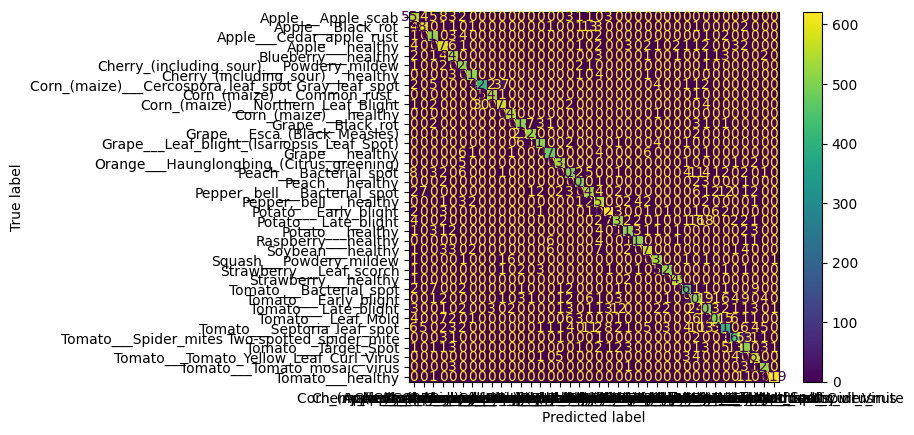

In [13]:
# Load your test dataset
test_ds = test_ds40

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision40_20e = precision_score(labels, predictions, average='micro')
recall40_20e = recall_score(labels, predictions, average='micro')
accuracy40_20e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision40_20e)
print("Recall:", recall40_20e)
print("Accuracy:", accuracy40_20e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()


In [34]:
tf. __version__

'2.16.1'

In [14]:
history_2 = model_dep.fit(
    train_ds40,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds40
)

Epoch 1/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0482 - accuracy: 0.9837 - val_loss: 0.2417 - val_accuracy: 0.9394
Epoch 2/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0353 - accuracy: 0.9887 - val_loss: 0.2697 - val_accuracy: 0.9335
Epoch 3/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0407 - accuracy: 0.9860 - val_loss: 0.3833 - val_accuracy: 0.9053
Epoch 4/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0378 - accuracy: 0.9875 - val_loss: 0.2467 - val_accuracy: 0.9376
Epoch 5/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0291 - accuracy: 0.9902 - val_loss: 0.3412 - val_accuracy: 0.9243
Epoch 6/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0312 - accuracy: 0.9900 - val_loss: 0.2474 - val_accuracy: 0.9387
Epoch 7/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0329 - accuracy: 0.9893 - val_loss: 0.2597 - val_accuracy:

1/1 [==============================] - 0s 25ms/step
Precision: 0.9483207806356876
Recall: 0.9472786698877362
Accuracy: 0.9483207806356876


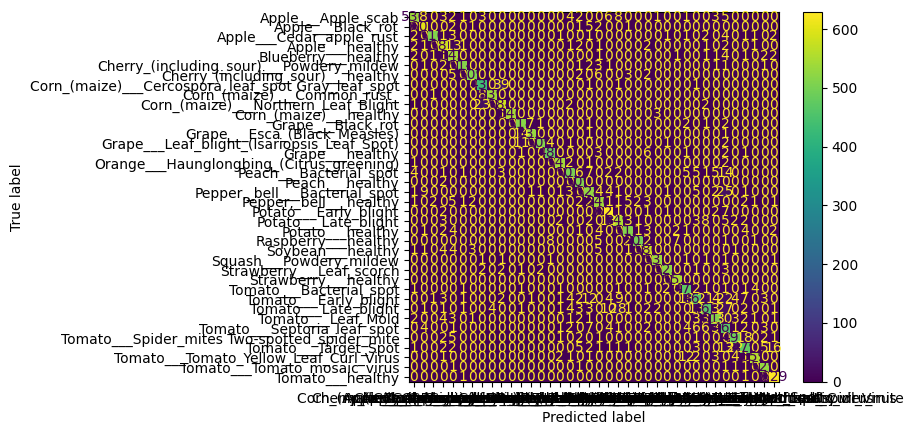

In [15]:
# Load your test dataset
test_ds = test_ds40

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision40_40e = precision_score(labels, predictions, average='micro')
recall40_40e = recall_score(labels, predictions, average='micro')
accuracy40_40e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision40_40e)
print("Recall:", recall40_20e)
print("Accuracy:", accuracy40_40e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [16]:
history_3 = model_dep.fit(
    train_ds40,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds40
)

Epoch 1/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0221 - accuracy: 0.9936 - val_loss: 0.2531 - val_accuracy: 0.9422
Epoch 2/20
878/878 [==============================] - 31s 36ms/step - loss: 0.0169 - accuracy: 0.9952 - val_loss: 0.2389 - val_accuracy: 0.9464
Epoch 3/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0174 - accuracy: 0.9945 - val_loss: 0.2750 - val_accuracy: 0.9408
Epoch 4/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0216 - accuracy: 0.9936 - val_loss: 0.2370 - val_accuracy: 0.9450
Epoch 5/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0205 - accuracy: 0.9933 - val_loss: 0.2675 - val_accuracy: 0.9446
Epoch 6/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0183 - accuracy: 0.9945 - val_loss: 0.2626 - val_accuracy: 0.9439
Epoch 7/20
878/878 [==============================] - 31s 36ms/step - loss: 0.0200 - accuracy: 0.9938 - val_loss: 0.2480 - val_accuracy:

1/1 [==============================] - 0s 25ms/step
Precision: 0.9477523565913505
Recall: 0.9477523565913505
Accuracy: 0.9477523565913505


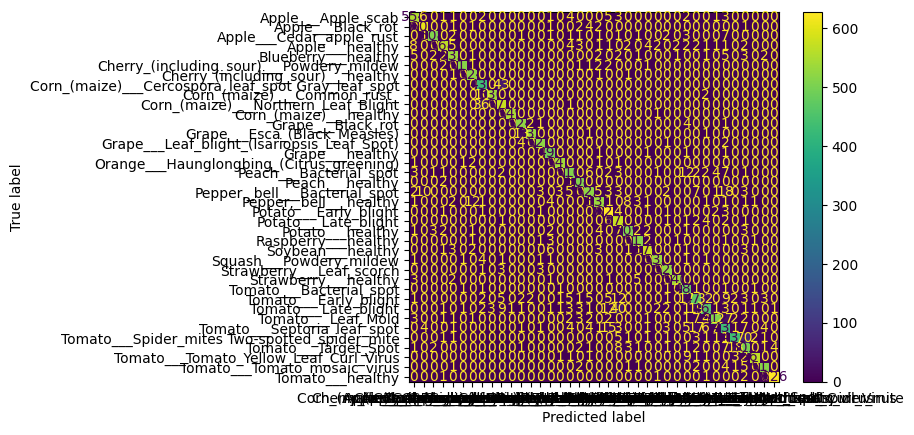

In [17]:
# Load your test dataset
test_ds = test_ds40

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision40_60e = precision_score(labels, predictions, average='micro')
recall40_60e = recall_score(labels, predictions, average='micro')
accuracy40_60e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision40_60e)
print("Recall:", recall40_60e)
print("Accuracy:", accuracy40_60e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [18]:
history_4 = model_dep.fit(
    train_ds40,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds40
)

Epoch 1/20
878/878 [==============================] - 31s 36ms/step - loss: 0.0177 - accuracy: 0.9950 - val_loss: 0.2241 - val_accuracy: 0.9530
Epoch 2/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0130 - accuracy: 0.9963 - val_loss: 0.2843 - val_accuracy: 0.9452
Epoch 3/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0145 - accuracy: 0.9957 - val_loss: 0.2641 - val_accuracy: 0.9504
Epoch 4/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0142 - accuracy: 0.9953 - val_loss: 0.2719 - val_accuracy: 0.9451
Epoch 5/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0159 - accuracy: 0.9951 - val_loss: 0.2462 - val_accuracy: 0.9473
Epoch 6/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0058 - accuracy: 0.9980 - val_loss: 0.3120 - val_accuracy: 0.9416
Epoch 7/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.2639 - val_accuracy:

1/1 [==============================] - 0s 24ms/step
Precision: 0.9469944578655677
Recall: 0.9469944578655677
Accuracy: 0.9469944578655677


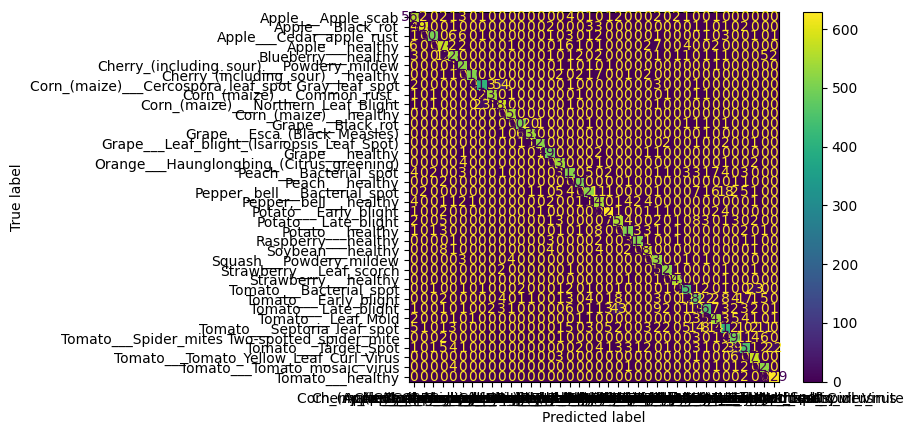

In [19]:
# Load your test dataset
test_ds = test_ds40

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision40_80e = precision_score(labels, predictions, average='micro')
recall40_80e = recall_score(labels, predictions, average='micro')
accuracy40_80e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision40_80e)
print("Recall:", recall40_80e)
print("Accuracy:", accuracy40_80e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [20]:
history_5 = model_dep.fit(
    train_ds40,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds40
)

Epoch 1/20
878/878 [==============================] - 31s 36ms/step - loss: 0.0087 - accuracy: 0.9974 - val_loss: 0.2451 - val_accuracy: 0.9501
Epoch 2/20
878/878 [==============================] - 31s 36ms/step - loss: 0.0099 - accuracy: 0.9971 - val_loss: 0.3595 - val_accuracy: 0.9366
Epoch 3/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0109 - accuracy: 0.9975 - val_loss: 0.2400 - val_accuracy: 0.9550
Epoch 4/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0103 - accuracy: 0.9966 - val_loss: 0.4152 - val_accuracy: 0.9282
Epoch 5/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0096 - accuracy: 0.9973 - val_loss: 0.2999 - val_accuracy: 0.9471
Epoch 6/20
878/878 [==============================] - 32s 36ms/step - loss: 0.0114 - accuracy: 0.9967 - val_loss: 0.2659 - val_accuracy: 0.9540
Epoch 7/20
878/878 [==============================] - 31s 36ms/step - loss: 0.0111 - accuracy: 0.9965 - val_loss: 0.3487 - val_accuracy:

1/1 [==============================] - 0s 24ms/step
Precision: 0.9441997063142438
Recall: 0.9441997063142438
Accuracy: 0.9441997063142438


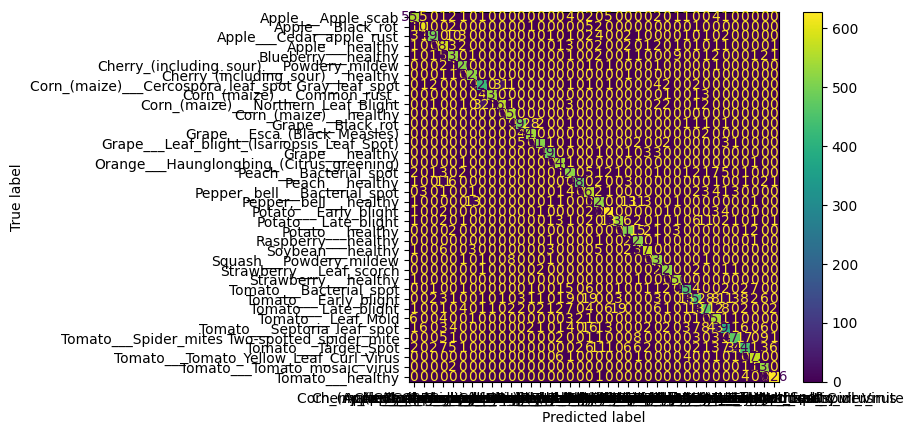

In [21]:
# Load your test dataset
test_ds = test_ds40

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision40_100e = precision_score(labels, predictions, average='micro')
recall40_100e = recall_score(labels, predictions, average='micro')
accuracy40_100e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision40_100e)
print("Recall:", recall40_100e)
print("Accuracy:", accuracy40_100e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
************************

In [11]:
history_1_50 = model_dep.fit(
    train_ds50,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds50
)

Epoch 1/20


2024-04-07 16:19:13.656965: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-04-07 16:19:14.310143: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-07 16:19:16.031646: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fd9733404f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-07 16:19:16.031675: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-07 16:19:16.036375: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-07 16:19:16.160672: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1097/1098 [============================>.] - ETA: 0s - loss: 2.3679 - accuracy: 0.3243

2024-04-07 16:19:59.773139: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:30: Filling up shuffle buffer (this may take a while): 427 of 1000
2024-04-07 16:20:00.799912: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1098/1098 [==============================] - 64s 43ms/step - loss: 2.3670 - accuracy: 0.3245 - val_loss: 1.0756 - val_accuracy: 0.6701
Epoch 2/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.8878 - accuracy: 0.7229 - val_loss: 0.5539 - val_accuracy: 0.8221
Epoch 3/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.5408 - accuracy: 0.8277 - val_loss: 0.4740 - val_accuracy: 0.8488
Epoch 4/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.3702 - accuracy: 0.8790 - val_loss: 0.3775 - val_accuracy: 0.8775
Epoch 5/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.2743 - accuracy: 0.9092 - val_loss: 0.2828 - val_accuracy: 0.9110
Epoch 6/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.2104 - accuracy: 0.9302 - val_loss: 0.2405 - val_accuracy: 0.9228
Epoch 7/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.1697 - accuracy: 0.9433 - val_loss: 0.2477 - val_accura

2024-04-07 16:32:35.589474: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:33: Filling up shuffle buffer (this may take a while): 1 of 1000


1/1 [==============================] - 0s 132ms/step


2024-04-07 16:32:40.122668: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1/1 [==============================] - 0s 25ms/step
Precision: 0.9443465408447501
Recall: 0.9443465408447501
Accuracy: 0.9443465408447501


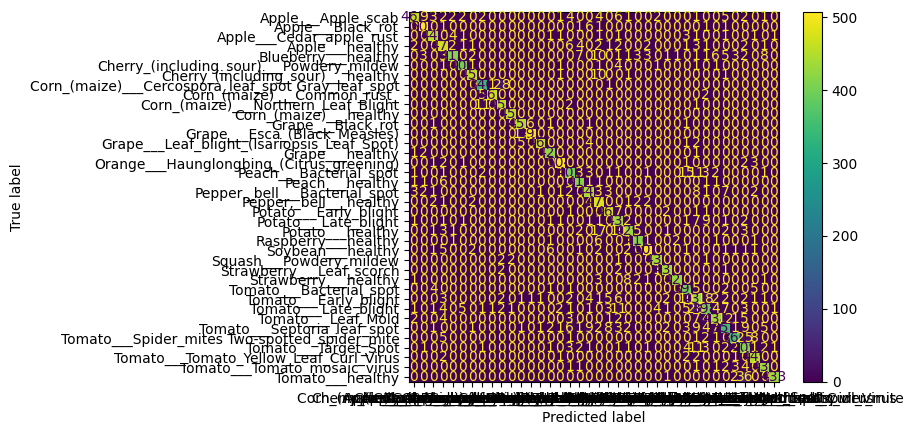

In [12]:
# Load your test dataset
test_ds = test_ds50

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision50_20e = precision_score(labels, predictions, average='micro')
recall50_20e = recall_score(labels, predictions, average='micro')
accuracy50_20e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision50_20e)
print("Recall:", recall50_20e)
print("Accuracy:", accuracy50_20e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [13]:
history_2_50 = model_dep.fit(
    train_ds50,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds50
)

Epoch 1/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0384 - accuracy: 0.9871 - val_loss: 0.3070 - val_accuracy: 0.9274
Epoch 2/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0336 - accuracy: 0.9892 - val_loss: 0.3289 - val_accuracy: 0.9250
Epoch 3/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0375 - accuracy: 0.9880 - val_loss: 0.2309 - val_accuracy: 0.9411
Epoch 4/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0300 - accuracy: 0.9904 - val_loss: 0.2260 - val_accuracy: 0.9459
Epoch 5/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0294 - accuracy: 0.9907 - val_loss: 0.2433 - val_accuracy: 0.9398
Epoch 6/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0299 - accuracy: 0.9909 - val_loss: 0.2555 - val_accuracy: 0.9310
Epoch 7/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0228 - accuracy: 0.9926 - val_loss: 0.2825 -

1/1 [==============================] - 0s 25ms/step
Precision: 0.9549201296117332
Recall: 0.9549201296117332
Accuracy: 0.9549201296117332


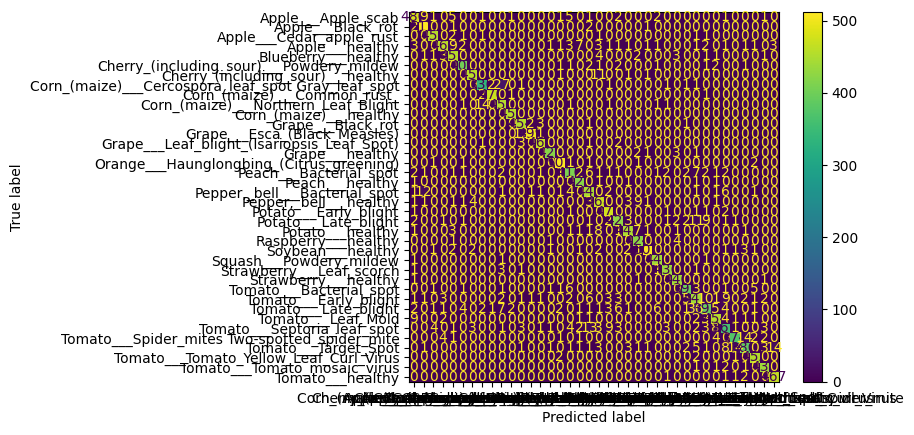

In [14]:
# Load your test dataset
test_ds = test_ds50

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision50_40e = precision_score(labels, predictions, average='micro')
recall50_40e = recall_score(labels, predictions, average='micro')
accuracy50_40e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision50_40e)
print("Recall:", recall50_40e)
print("Accuracy:", accuracy50_40e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [15]:
history_3_50 = model_dep.fit(
    train_ds50,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds50
)

Epoch 1/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0179 - accuracy: 0.9948 - val_loss: 0.2251 - val_accuracy: 0.9510
Epoch 2/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0187 - accuracy: 0.9945 - val_loss: 0.2788 - val_accuracy: 0.9426
Epoch 3/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0183 - accuracy: 0.9942 - val_loss: 0.2846 - val_accuracy: 0.9411
Epoch 4/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0165 - accuracy: 0.9945 - val_loss: 0.2318 - val_accuracy: 0.9512
Epoch 5/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0166 - accuracy: 0.9953 - val_loss: 0.2854 - val_accuracy: 0.9373
Epoch 6/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0169 - accuracy: 0.9949 - val_loss: 0.2196 - val_accuracy: 0.9512
Epoch 7/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0146 - accuracy: 0.9956 - val_loss: 0.2598 -

1/1 [==============================] - 0s 25ms/step
Precision: 0.952418850548576
Recall: 0.952418850548576
Accuracy: 0.952418850548576


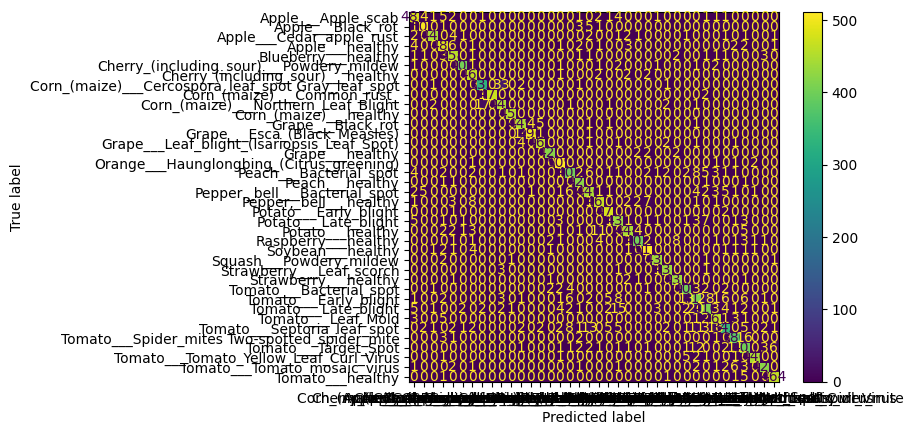

In [16]:
# Load your test dataset
test_ds = test_ds50

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision50_60e = precision_score(labels, predictions, average='micro')
recall50_60e = recall_score(labels, predictions, average='micro')
accuracy50_60e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision50_60e)
print("Recall:", recall50_60e)
print("Accuracy:", accuracy50_60e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [17]:
history_4_50 = model_dep.fit(
    train_ds50,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds50
)

Epoch 1/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0101 - accuracy: 0.9970 - val_loss: 0.2709 - val_accuracy: 0.9488
Epoch 2/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0165 - accuracy: 0.9953 - val_loss: 0.2487 - val_accuracy: 0.9493
Epoch 3/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.1942 - val_accuracy: 0.9598
Epoch 4/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0152 - accuracy: 0.9959 - val_loss: 0.2703 - val_accuracy: 0.9446
Epoch 5/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0064 - accuracy: 0.9985 - val_loss: 0.2366 - val_accuracy: 0.9559
Epoch 6/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0191 - accuracy: 0.9946 - val_loss: 0.2955 - val_accuracy: 0.9413
Epoch 7/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0097 - accuracy: 0.9971 - val_loss: 0.2659 -

1/1 [==============================] - 0s 29ms/step
Precision: 0.9405377749985788
Recall: 0.9405377749985788
Accuracy: 0.9405377749985788


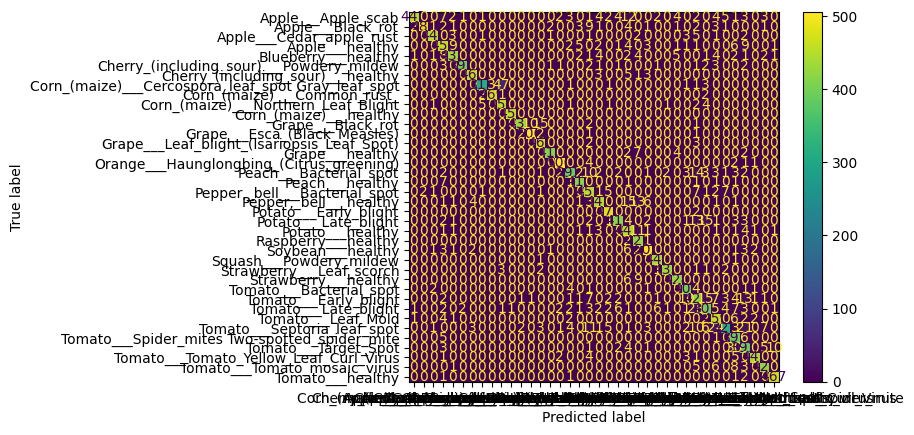

In [18]:
# Load your test dataset
test_ds = test_ds50

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision50_80e = precision_score(labels, predictions, average='micro')
recall50_80e = recall_score(labels, predictions, average='micro')
accuracy50_80e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision50_80e)
print("Recall:", recall50_80e)
print("Accuracy:", accuracy50_80e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [19]:
history_5_50 = model_dep.fit(
    train_ds50,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds50
)

Epoch 1/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.2499 - val_accuracy: 0.9537
Epoch 2/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0093 - accuracy: 0.9970 - val_loss: 0.2448 - val_accuracy: 0.9585
Epoch 3/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0143 - accuracy: 0.9964 - val_loss: 0.1961 - val_accuracy: 0.9635
Epoch 4/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0076 - accuracy: 0.9982 - val_loss: 0.2694 - val_accuracy: 0.9498
Epoch 5/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0144 - accuracy: 0.9960 - val_loss: 0.2571 - val_accuracy: 0.9496
Epoch 6/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.2823 - val_accuracy: 0.9508
Epoch 7/20
1098/1098 [==============================] - 36s 33ms/step - loss: 0.0107 - accuracy: 0.9974 - val_loss: 0.3246 -

1/1 [==============================] - 0s 24ms/step
Precision: 0.955318060371781
Recall: 0.955318060371781
Accuracy: 0.955318060371781


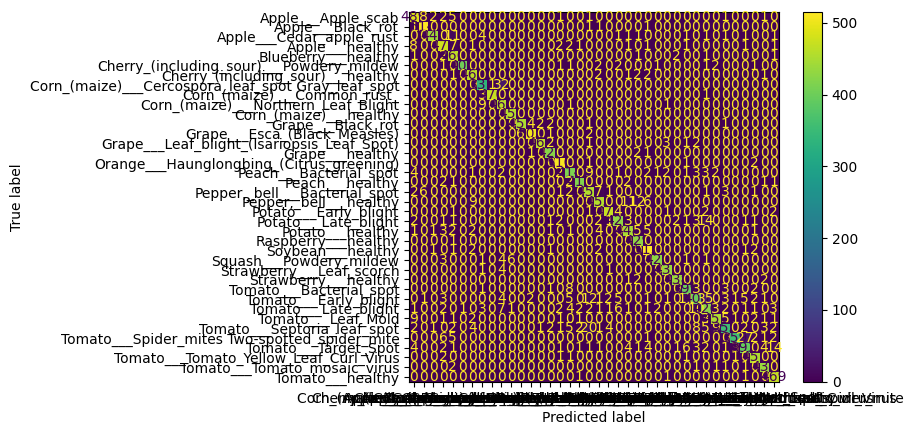

In [20]:
# Load your test dataset
test_ds = test_ds50

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision50_100e = precision_score(labels, predictions, average='micro')
recall50_100e = recall_score(labels, predictions, average='micro')
accuracy50_100e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision50_100e)
print("Recall:", recall50_100e)
print("Accuracy:", accuracy50_100e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
//////////////////////////////////

In [29]:
history_1_60 = model_dep.fit(
    train_ds60,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds60
)

Epoch 1/20
1318/1318 [==============================] - 54s 39ms/step - loss: 2.2821 - accuracy: 0.3460 - val_loss: 1.0171 - val_accuracy: 0.6847
Epoch 2/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.7306 - accuracy: 0.7687 - val_loss: 0.4750 - val_accuracy: 0.8472
Epoch 3/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.4057 - accuracy: 0.8700 - val_loss: 0.3277 - val_accuracy: 0.8937
Epoch 4/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.2831 - accuracy: 0.9078 - val_loss: 0.2681 - val_accuracy: 0.9150
Epoch 5/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.2088 - accuracy: 0.9302 - val_loss: 0.2466 - val_accuracy: 0.9220
Epoch 6/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.1612 - accuracy: 0.9463 - val_loss: 0.2808 - val_accuracy: 0.9154
Epoch 7/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.1365 - accuracy: 0.9543 - val_loss: 0.1781 -

1/1 [==============================] - 0s 111ms/step
Precision: 0.9579987207732216
Recall: 0.9579987207732216
Accuracy: 0.9579987207732216


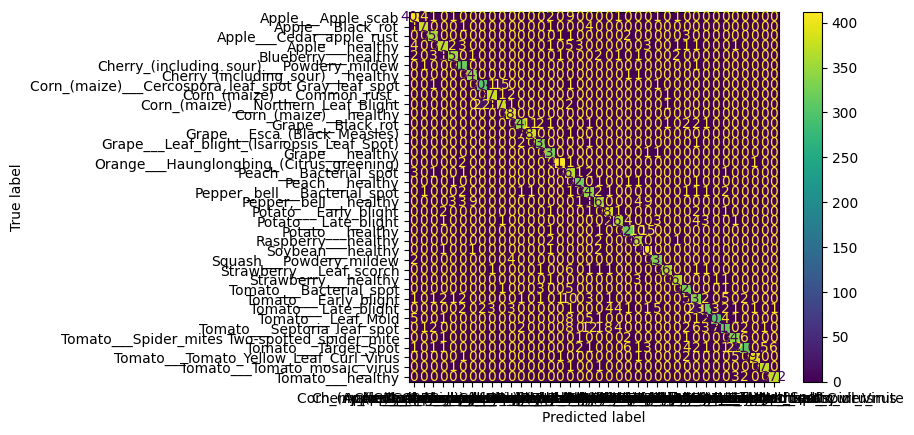

In [30]:
# Load your test dataset
test_ds = test_ds60

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision60_20e = precision_score(labels, predictions, average='micro')
recall60_20e = recall_score(labels, predictions, average='micro')
accuracy60_20e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision60_20e)
print("Recall:", recall60_20e)
print("Accuracy:", accuracy60_20e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [31]:
history_2_60 = model_dep.fit(
    train_ds60,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds60
)

Epoch 1/20
1318/1318 [==============================] - 52s 39ms/step - loss: 0.0302 - accuracy: 0.9899 - val_loss: 0.2113 - val_accuracy: 0.9552
Epoch 2/20
1318/1318 [==============================] - 51s 39ms/step - loss: 0.0336 - accuracy: 0.9892 - val_loss: 0.1830 - val_accuracy: 0.9517
Epoch 3/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0287 - accuracy: 0.9910 - val_loss: 0.1788 - val_accuracy: 0.9547
Epoch 4/20
1318/1318 [==============================] - 51s 39ms/step - loss: 0.0272 - accuracy: 0.9912 - val_loss: 0.1510 - val_accuracy: 0.9640
Epoch 5/20
1318/1318 [==============================] - 51s 39ms/step - loss: 0.0266 - accuracy: 0.9915 - val_loss: 0.1748 - val_accuracy: 0.9580
Epoch 6/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0283 - accuracy: 0.9909 - val_loss: 0.1863 - val_accuracy: 0.9552
Epoch 7/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0241 - accuracy: 0.9920 - val_loss: 0.1598 -

1/1 [==============================] - 0s 24ms/step
Precision: 0.9631156278871438
Recall: 0.9631156278871438
Accuracy: 0.9631156278871438


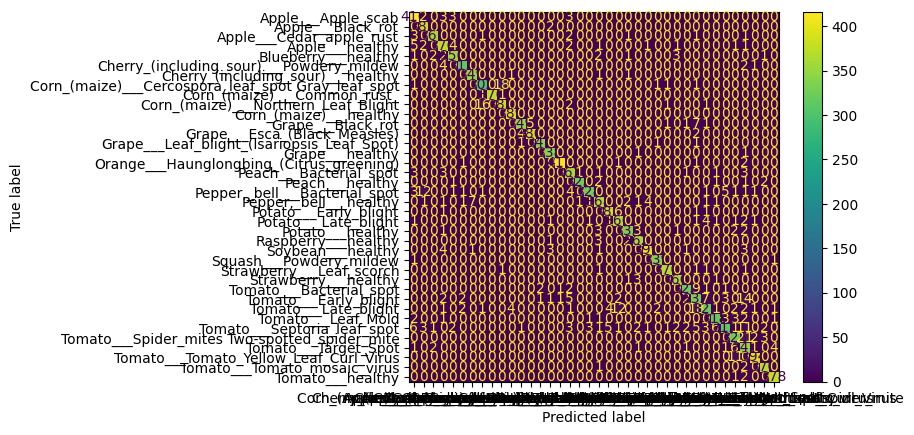

In [32]:
# Load your test dataset
test_ds = test_ds60

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision60_40e = precision_score(labels, predictions, average='micro')
recall60_40e = recall_score(labels, predictions, average='micro')
accuracy60_40e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision60_40e)
print("Recall:", recall60_40e)
print("Accuracy:", accuracy60_40e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [33]:
history_3_60 = model_dep.fit(
    train_ds60,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds60
)

Epoch 1/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0158 - accuracy: 0.9951 - val_loss: 0.1514 - val_accuracy: 0.9669
Epoch 2/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0166 - accuracy: 0.9950 - val_loss: 0.2362 - val_accuracy: 0.9503
Epoch 3/20
1318/1318 [==============================] - 50s 38ms/step - loss: 0.0182 - accuracy: 0.9946 - val_loss: 0.2076 - val_accuracy: 0.9551
Epoch 4/20
1318/1318 [==============================] - 51s 39ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.1918 - val_accuracy: 0.9592
Epoch 5/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0150 - accuracy: 0.9951 - val_loss: 0.1621 - val_accuracy: 0.9670
Epoch 6/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0135 - accuracy: 0.9960 - val_loss: 0.1743 - val_accuracy: 0.9634
Epoch 7/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0153 - accuracy: 0.9954 - val_loss: 0.1813 -

1/1 [==============================] - 0s 24ms/step
Precision: 0.9688010802359462
Recall: 0.9688010802359462
Accuracy: 0.9688010802359462


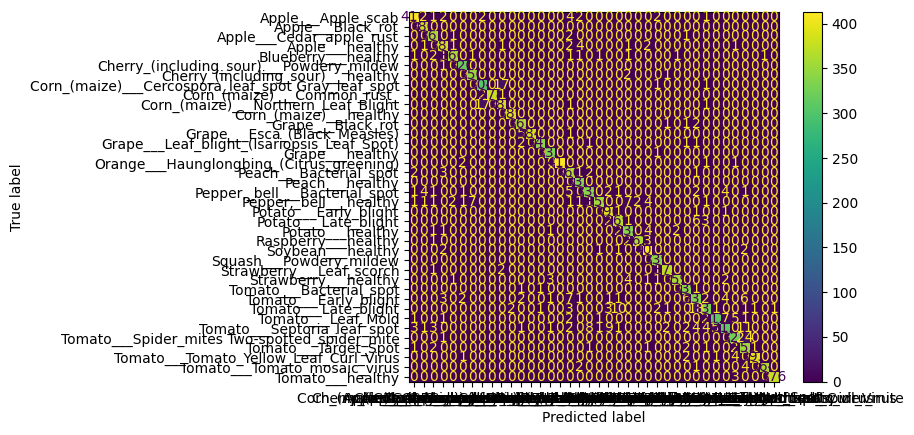

In [34]:
# Load your test dataset
test_ds = test_ds60

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision60_60e = precision_score(labels, predictions, average='micro')
recall60_60e = recall_score(labels, predictions, average='micro')
accuracy60_60e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision60_60e)
print("Recall:", recall60_60e)
print("Accuracy:", accuracy60_60e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [35]:
history_4_60 = model_dep.fit(
    train_ds60,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds60
)

Epoch 1/20
1318/1318 [==============================] - 50s 38ms/step - loss: 0.0084 - accuracy: 0.9974 - val_loss: 0.1360 - val_accuracy: 0.9725
Epoch 2/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0129 - accuracy: 0.9958 - val_loss: 0.2134 - val_accuracy: 0.9577
Epoch 3/20
1318/1318 [==============================] - 50s 38ms/step - loss: 0.0136 - accuracy: 0.9961 - val_loss: 0.1642 - val_accuracy: 0.9655
Epoch 4/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0104 - accuracy: 0.9971 - val_loss: 0.3186 - val_accuracy: 0.9396
Epoch 5/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0160 - accuracy: 0.9953 - val_loss: 0.1444 - val_accuracy: 0.9692
Epoch 6/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0054 - accuracy: 0.9985 - val_loss: 0.1848 - val_accuracy: 0.9641
Epoch 7/20
1318/1318 [==============================] - 51s 39ms/step - loss: 0.0107 - accuracy: 0.9970 - val_loss: 0.1460 -

1/1 [==============================] - 0s 23ms/step
Precision: 0.9723544879539479
Recall: 0.9723544879539479
Accuracy: 0.9723544879539479


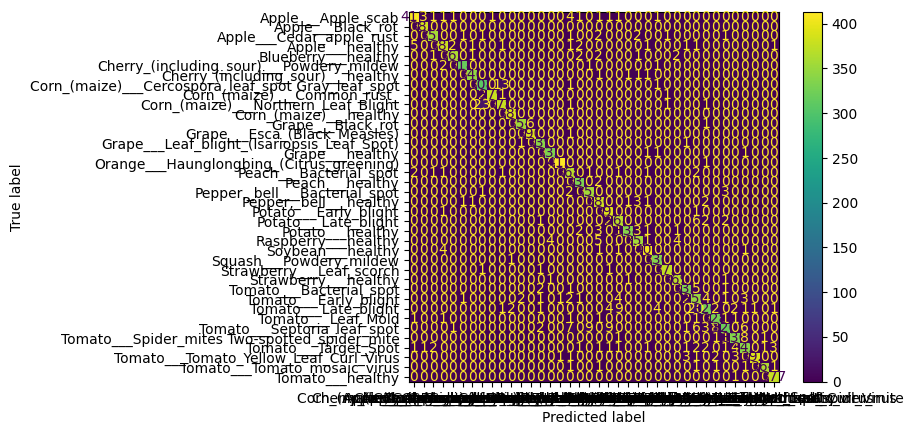

In [36]:
# Load your test dataset
test_ds = test_ds60

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision60_80e = precision_score(labels, predictions, average='micro')
recall60_80e = recall_score(labels, predictions, average='micro')
accuracy60_80e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision60_80e)
print("Recall:", recall60_80e)
print("Accuracy:", accuracy60_80e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [37]:
history_5_60 = model_dep.fit(
    train_ds60,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds60
)

Epoch 1/20
1318/1318 [==============================] - 51s 39ms/step - loss: 0.0106 - accuracy: 0.9970 - val_loss: 0.1575 - val_accuracy: 0.9694
Epoch 2/20
1318/1318 [==============================] - 50s 38ms/step - loss: 0.0055 - accuracy: 0.9983 - val_loss: 0.1482 - val_accuracy: 0.9731
Epoch 3/20
1318/1318 [==============================] - 50s 38ms/step - loss: 0.0136 - accuracy: 0.9965 - val_loss: 0.1923 - val_accuracy: 0.9673
Epoch 4/20
1318/1318 [==============================] - 50s 38ms/step - loss: 0.0106 - accuracy: 0.9971 - val_loss: 0.2584 - val_accuracy: 0.9552
Epoch 5/20
1318/1318 [==============================] - 50s 38ms/step - loss: 0.0080 - accuracy: 0.9979 - val_loss: 0.2662 - val_accuracy: 0.9605
Epoch 6/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0101 - accuracy: 0.9974 - val_loss: 0.1806 - val_accuracy: 0.9683
Epoch 7/20
1318/1318 [==============================] - 51s 38ms/step - loss: 0.0096 - accuracy: 0.9975 - val_loss: 0.1913 -

1/1 [==============================] - 0s 24ms/step
Precision: 0.9607703787932628
Recall: 0.9607703787932628
Accuracy: 0.9607703787932628


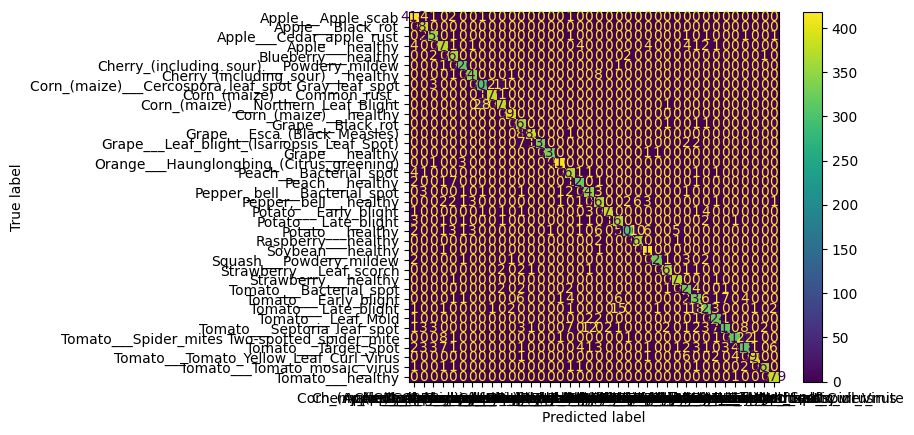

In [38]:
# Load your test dataset
test_ds = test_ds60

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision60_100e = precision_score(labels, predictions, average='micro')
recall60_100e = recall_score(labels, predictions, average='micro')
accuracy60_100e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision60_100e)
print("Recall:", recall60_100e)
print("Accuracy:", accuracy60_100e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
////////////////////////////

In [10]:
history_1_70 = model_dep.fit(
    train_ds70,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds70
)

Epoch 1/20


2024-04-07 19:06:04.920797: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-04-07 19:06:05.573348: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-07 19:06:07.293058: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f9ed583df80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-07 19:06:07.293086: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-07 19:06:07.297830: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-07 19:06:07.420955: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1537/1537 [==============================] - ETA: 0s - loss: 1.9465 - accuracy: 0.4364

2024-04-07 19:07:03.012686: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 102 of 1000
2024-04-07 19:07:04.819501: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1537/1537 [==============================] - 75s 38ms/step - loss: 1.9465 - accuracy: 0.4364 - val_loss: 0.7613 - val_accuracy: 0.7630
Epoch 2/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.6077 - accuracy: 0.8069 - val_loss: 0.4225 - val_accuracy: 0.8668
Epoch 3/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.3585 - accuracy: 0.8844 - val_loss: 0.2541 - val_accuracy: 0.9176
Epoch 4/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.2523 - accuracy: 0.9177 - val_loss: 0.2713 - val_accuracy: 0.9138
Epoch 5/20
1537/1537 [==============================] - 46s 30ms/step - loss: 0.1901 - accuracy: 0.9363 - val_loss: 0.3021 - val_accuracy: 0.9037
Epoch 6/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.1506 - accuracy: 0.9501 - val_loss: 0.1914 - val_accuracy: 0.9404
Epoch 7/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.1190 - accuracy: 0.9599 - val_loss: 0.2369 - val_accura

2024-04-07 19:21:52.233999: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:23: Filling up shuffle buffer (this may take a while): 1 of 1000


1/1 [==============================] - 0s 131ms/step


2024-04-07 19:21:54.857748: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1/1 [==============================] - 0s 25ms/step
Precision: 0.9707077388264197
Recall: 0.9707077388264197
Accuracy: 0.9707077388264197


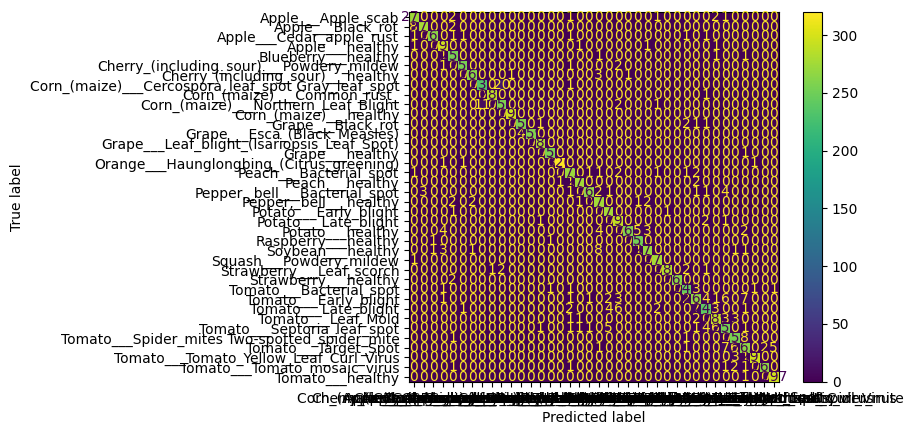

In [11]:
# Load your test dataset
test_ds = test_ds70

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision70_20e = precision_score(labels, predictions, average='micro')
recall70_20e = recall_score(labels, predictions, average='micro')
accuracy70_20e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision70_20e)
print("Recall:", recall70_20e)
print("Accuracy:", accuracy70_20e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [12]:
history_2_70 = model_dep.fit(
    train_ds70,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds70
)

Epoch 1/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0279 - accuracy: 0.9912 - val_loss: 0.1588 - val_accuracy: 0.9645
Epoch 2/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0266 - accuracy: 0.9914 - val_loss: 0.1751 - val_accuracy: 0.9612
Epoch 3/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.0262 - accuracy: 0.9914 - val_loss: 0.1535 - val_accuracy: 0.9634
Epoch 4/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.0246 - accuracy: 0.9917 - val_loss: 0.2159 - val_accuracy: 0.9483
Epoch 5/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.0270 - accuracy: 0.9912 - val_loss: 0.1854 - val_accuracy: 0.9555
Epoch 6/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0203 - accuracy: 0.9933 - val_loss: 0.1452 - val_accuracy: 0.9668
Epoch 7/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0230 - accuracy: 0.9928 - val_loss: 0.1687 -

1/1 [==============================] - 0s 24ms/step
Precision: 0.9695738448455069
Recall: 0.9695738448455069
Accuracy: 0.9695738448455069


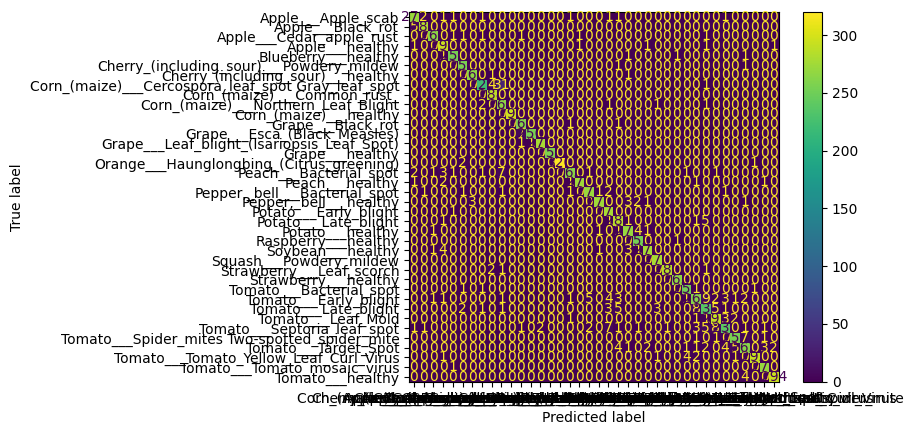

In [13]:
# Load your test dataset
test_ds = test_ds70

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision70_40e = precision_score(labels, predictions, average='micro')
recall70_40e = recall_score(labels, predictions, average='micro')
accuracy70_40e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision70_40e)
print("Recall:", recall70_40e)
print("Accuracy:", accuracy70_40e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [14]:
history_3_70 = model_dep.fit(
    train_ds70,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds70
)

Epoch 1/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0137 - accuracy: 0.9961 - val_loss: 0.2003 - val_accuracy: 0.9568
Epoch 2/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0134 - accuracy: 0.9961 - val_loss: 0.1469 - val_accuracy: 0.9723
Epoch 3/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.0146 - accuracy: 0.9955 - val_loss: 0.1817 - val_accuracy: 0.9648
Epoch 4/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0139 - accuracy: 0.9956 - val_loss: 0.1550 - val_accuracy: 0.9687
Epoch 5/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.0139 - accuracy: 0.9960 - val_loss: 0.1789 - val_accuracy: 0.9663
Epoch 6/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0130 - accuracy: 0.9961 - val_loss: 0.1483 - val_accuracy: 0.9708
Epoch 7/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0138 - accuracy: 0.9954 - val_loss: 0.1579 -

1/1 [==============================] - 0s 25ms/step
Precision: 0.9691958801852026
Recall: 0.9691958801852026
Accuracy: 0.9691958801852026


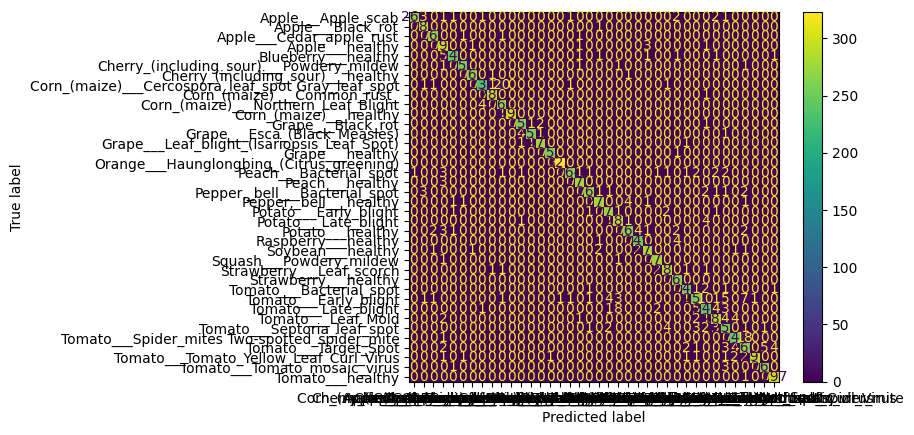

In [15]:
# Load your test dataset
test_ds = test_ds70

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision70_60e = precision_score(labels, predictions, average='micro')
recall70_60e = recall_score(labels, predictions, average='micro')
accuracy70_60e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision70_60e)
print("Recall:", recall70_60e)
print("Accuracy:", accuracy70_60e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [16]:
history_4_70 = model_dep.fit(
    train_ds70,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds70
)

Epoch 1/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0112 - accuracy: 0.9967 - val_loss: 0.2424 - val_accuracy: 0.9571
Epoch 2/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0097 - accuracy: 0.9975 - val_loss: 0.2080 - val_accuracy: 0.9619
Epoch 3/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0124 - accuracy: 0.9965 - val_loss: 0.1904 - val_accuracy: 0.9631
Epoch 4/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0095 - accuracy: 0.9972 - val_loss: 0.2054 - val_accuracy: 0.9639
Epoch 5/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0113 - accuracy: 0.9970 - val_loss: 0.1661 - val_accuracy: 0.9687
Epoch 6/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0102 - accuracy: 0.9976 - val_loss: 0.1586 - val_accuracy: 0.9672
Epoch 7/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0093 - accuracy: 0.9976 - val_loss: 0.1465 -

1/1 [==============================] - 0s 24ms/step
Precision: 0.9708967211565719
Recall: 0.9708967211565719
Accuracy: 0.9708967211565719


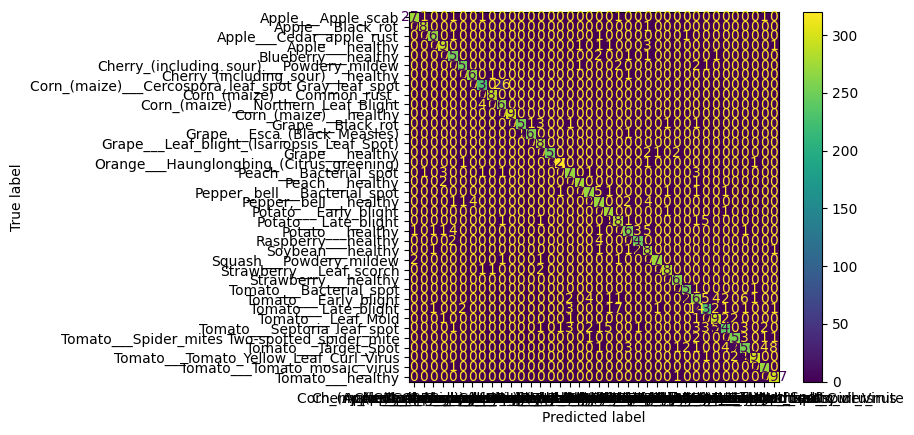

In [17]:
# Load your test dataset
test_ds = test_ds70

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision70_80e = precision_score(labels, predictions, average='micro')
recall70_80e = recall_score(labels, predictions, average='micro')
accuracy70_80e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision70_80e)
print("Recall:", recall70_80e)
print("Accuracy:", accuracy70_80e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [18]:
history_5_70 = model_dep.fit(
    train_ds70,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds70
)

Epoch 1/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0066 - accuracy: 0.9983 - val_loss: 0.2769 - val_accuracy: 0.9630
Epoch 2/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0134 - accuracy: 0.9971 - val_loss: 0.1332 - val_accuracy: 0.9736
Epoch 3/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0071 - accuracy: 0.9979 - val_loss: 0.2347 - val_accuracy: 0.9641
Epoch 4/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.0128 - accuracy: 0.9965 - val_loss: 0.2169 - val_accuracy: 0.9656
Epoch 5/20
1537/1537 [==============================] - 45s 30ms/step - loss: 0.0077 - accuracy: 0.9979 - val_loss: 0.1933 - val_accuracy: 0.9614
Epoch 6/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0092 - accuracy: 0.9976 - val_loss: 0.1974 - val_accuracy: 0.9684
Epoch 7/20
1537/1537 [==============================] - 45s 29ms/step - loss: 0.0080 - accuracy: 0.9977 - val_loss: 0.1837 -

1/1 [==============================] - 0s 25ms/step
Precision: 0.969668336010583
Recall: 0.969668336010583
Accuracy: 0.969668336010583


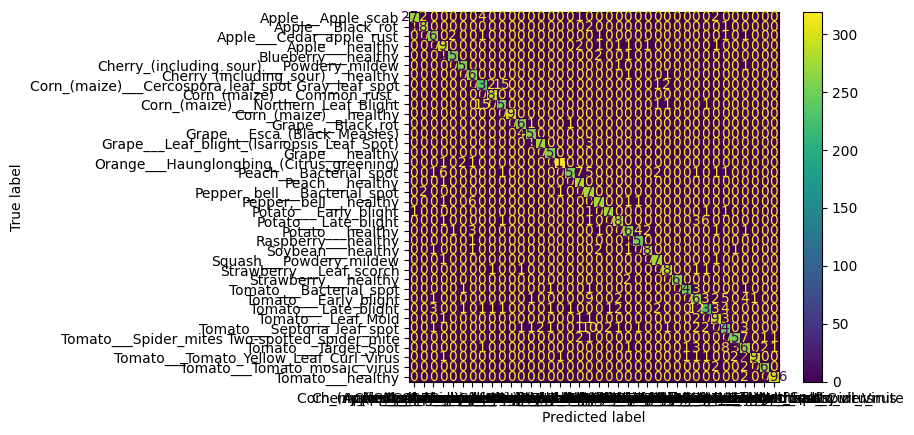

In [19]:
# Load your test dataset
test_ds = test_ds70

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision70_100e = precision_score(labels, predictions, average='micro')
recall70_100e = recall_score(labels, predictions, average='micro')
accuracy70_100e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision70_100e)
print("Recall:", recall70_100e)
print("Accuracy:", accuracy70_100e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
//////////////////////////////

In [8]:
history_1_80 = model_dep.fit(
    train_ds80,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds80
)

Epoch 1/20


2024-04-09 13:41:48.755195: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8905
2024-04-09 13:41:48.815990: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-04-09 13:41:49.626027: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f1d04a13740 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-09 13:41:49.626042: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-04-09 13:41:49.628437: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-09 13:41:49.678747: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1757/1757 [==============================] - ETA: 0s - loss: 1.9763 - accuracy: 0.4294

2024-04-09 13:42:46.072049: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:20: Filling up shuffle buffer (this may take a while): 1 of 1000
2024-04-09 13:42:48.327573: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


1757/1757 [==============================] - 72s 34ms/step - loss: 1.9763 - accuracy: 0.4294 - val_loss: 0.8349 - val_accuracy: 0.7349
Epoch 2/20
1757/1757 [==============================] - 45s 25ms/step - loss: 0.6197 - accuracy: 0.8039 - val_loss: 0.3841 - val_accuracy: 0.8756
Epoch 3/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.3555 - accuracy: 0.8850 - val_loss: 0.2507 - val_accuracy: 0.9188
Epoch 4/20
1757/1757 [==============================] - 45s 25ms/step - loss: 0.2431 - accuracy: 0.9201 - val_loss: 0.2262 - val_accuracy: 0.9287
Epoch 5/20
1757/1757 [==============================] - 45s 25ms/step - loss: 0.1777 - accuracy: 0.9400 - val_loss: 0.2662 - val_accuracy: 0.9127
Epoch 6/20
1757/1757 [==============================] - 45s 25ms/step - loss: 0.1310 - accuracy: 0.9564 - val_loss: 0.1414 - val_accuracy: 0.9539
Epoch 7/20
1757/1757 [==============================] - 45s 25ms/step - loss: 0.1048 - accuracy: 0.9658 - val_loss: 0.1278 - val_accura

1/1 [==============================] - 0s 11ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       198
           1       1.00      0.99      0.99       182
           2       0.97      0.97      0.97       178
           3       0.95      0.99      0.97       191
           4       0.98      0.98      0.98       199
           5       0.99      0.97      0.98       184
           6       0.97      1.00      0.99       183
           7       0.95      0.92      0.93       159
           8       1.00      0.99      0.99       175
           9       0.95      0.97      0.96       215
          10       0.98      1.00      0.99       183
          11       0.98      0.99      0.99       195
          12       1.00      0.99      0.99       179
          13       0.98      0.99      0.99       173
          14       0.99      0.99      0.99       163
          15       0.99      0.99      0.99       194
      

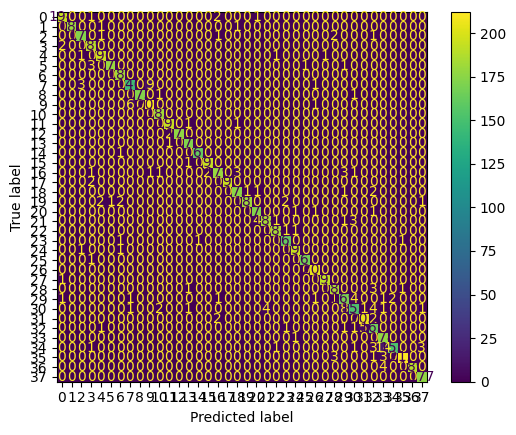

In [19]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Load your test dataset
test_ds = test_ds80

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Generate classification report without specifying target_names
report = classification_report(labels, predictions)

# Display classification report
print("Classification Report:")
print(report)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix)
disp.plot()
plt.show()


1/1 [==============================] - 0s 12ms/step


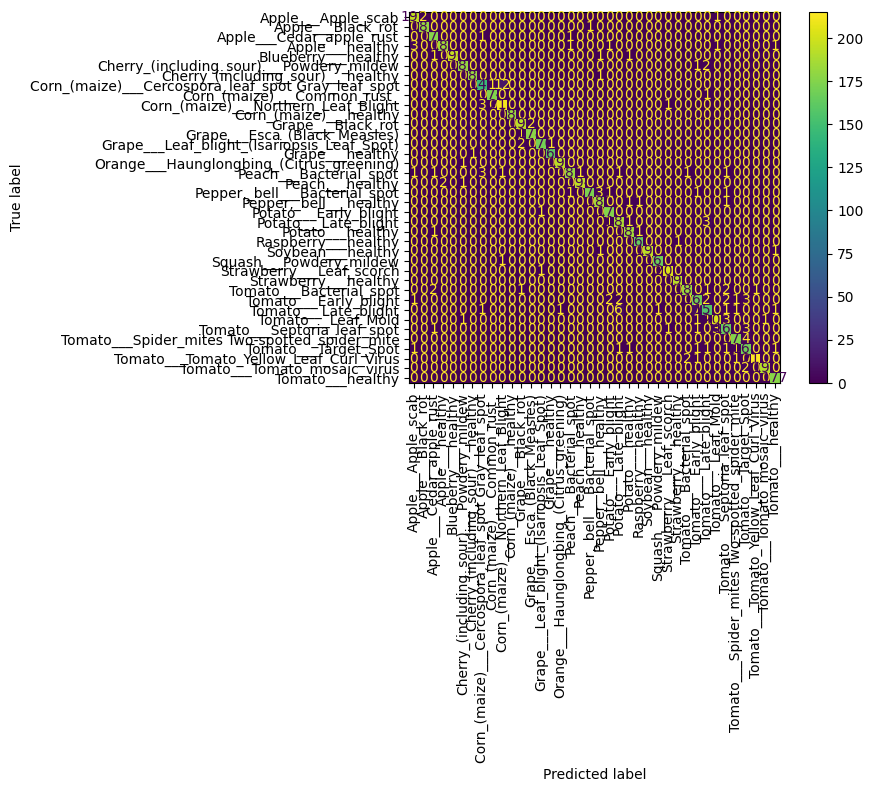

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Provided class names
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix with rotated predicted labels
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
plt.figure(figsize=(10, 8))  # Adjust figure size as needed
disp.plot(ax=plt.gca())  # Plot confusion matrix
plt.xticks(rotation=90)  # Rotate tick labels by 90 degrees
plt.tight_layout()  # Ensure proper layout
plt.show()


In [35]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Provided class names
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Generate classification report using provided class names
report = classification_report(labels, predictions, target_names=class_names)

# Display classification report
print("Classification Report:")
print(report)


1/1 [==============================] - 0s 12ms/step
Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.98      0.98      0.98       198
                                 Apple___Black_rot       1.00      0.99      0.99       182
                          Apple___Cedar_apple_rust       0.97      0.97      0.97       178
                                   Apple___healthy       0.95      0.99      0.97       191
                               Blueberry___healthy       0.98      0.98      0.98       199
          Cherry_(including_sour)___Powdery_mildew       0.99      0.97      0.98       184
                 Cherry_(including_sour)___healthy       0.97      1.00      0.99       183
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.92      0.93       159
                       Corn_(maize)___Common_rust_       1.00      0.99      0.99       175
    

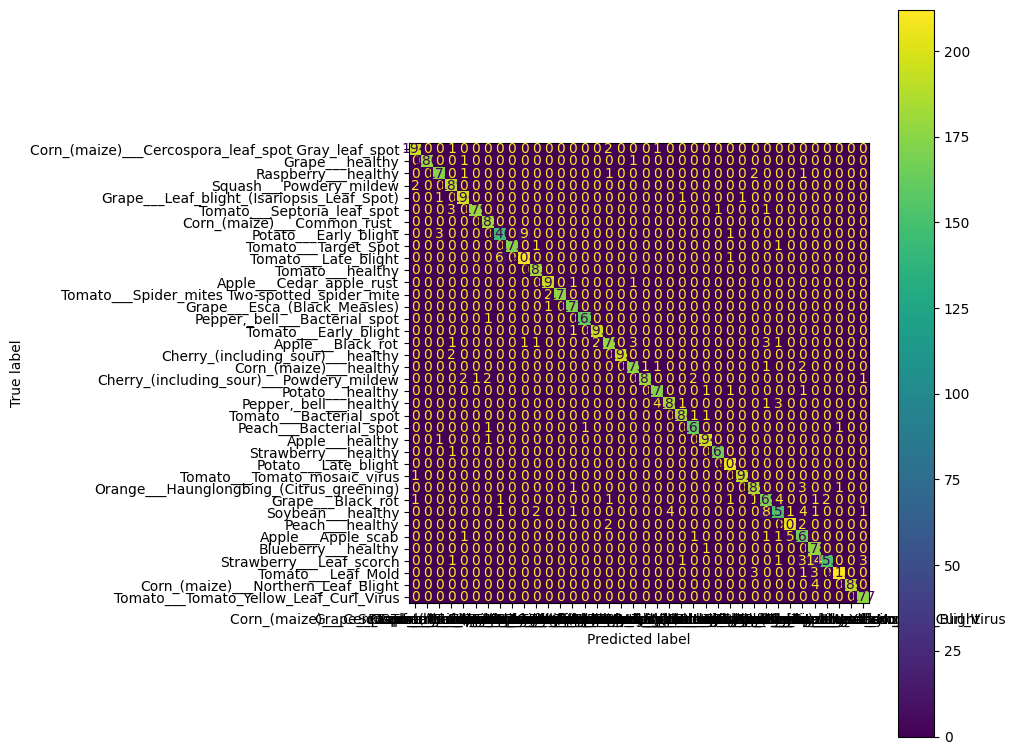

In [34]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix with class names in ascending order
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)

plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
disp.plot(ax=plt.gca())
plt.tight_layout()  # Ensure proper layout
plt.show()

In [36]:
history_2_80 = model_dep.fit(
    train_ds80,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds80
)

Epoch 1/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0268 - accuracy: 0.9917 - val_loss: 0.1439 - val_accuracy: 0.9592
Epoch 2/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0257 - accuracy: 0.9916 - val_loss: 0.1177 - val_accuracy: 0.9706
Epoch 3/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0215 - accuracy: 0.9933 - val_loss: 0.1078 - val_accuracy: 0.9688
Epoch 4/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0213 - accuracy: 0.9932 - val_loss: 0.1075 - val_accuracy: 0.9712
Epoch 5/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0207 - accuracy: 0.9933 - val_loss: 0.1534 - val_accuracy: 0.9632
Epoch 6/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0230 - accuracy: 0.9933 - val_loss: 0.1409 - val_accuracy: 0.9638
Epoch 7/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0195 - accuracy: 0.9941 - val_loss: 0.1321 -

1/1 [==============================] - 0s 24ms/step
Precision: 0.9733824154042192
Recall: 0.9733824154042192
Accuracy: 0.9733824154042192


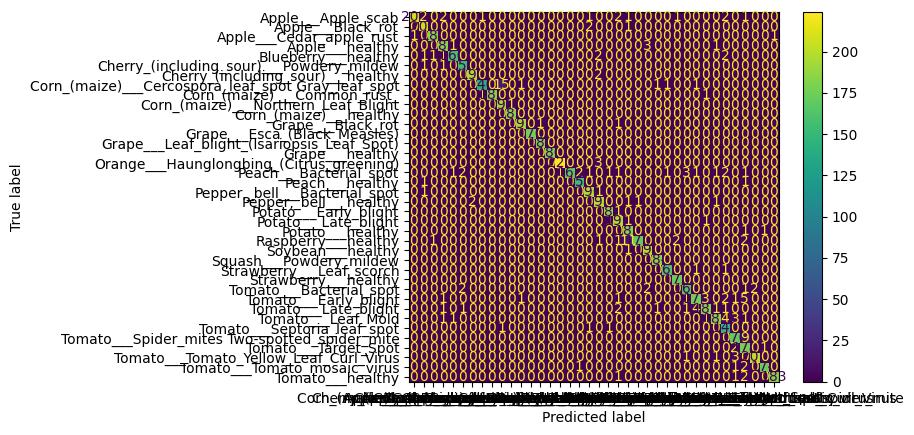

In [14]:
# Load your test dataset
test_ds = test_ds80

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision80_40e = precision_score(labels, predictions, average='micro')
recall80_40e = recall_score(labels, predictions, average='micro')
accuracy80_40e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision80_40e)
print("Recall:", recall80_40e)
print("Accuracy:", accuracy80_40e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [37]:
history_3_80 = model_dep.fit(
    train_ds80,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds80
)

Epoch 1/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0132 - accuracy: 0.9958 - val_loss: 0.1507 - val_accuracy: 0.9686
Epoch 2/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0140 - accuracy: 0.9959 - val_loss: 0.1294 - val_accuracy: 0.9736
Epoch 3/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0119 - accuracy: 0.9966 - val_loss: 0.1175 - val_accuracy: 0.9730
Epoch 4/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0145 - accuracy: 0.9960 - val_loss: 0.1167 - val_accuracy: 0.9737
Epoch 5/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0121 - accuracy: 0.9962 - val_loss: 0.2574 - val_accuracy: 0.9466
Epoch 6/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0123 - accuracy: 0.9965 - val_loss: 0.1590 - val_accuracy: 0.9638
Epoch 7/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0112 - accuracy: 0.9964 - val_loss: 0.1331 -

1/1 [==============================] - 0s 24ms/step
Precision: 0.9764972391335127
Recall: 0.9764972391335127
Accuracy: 0.9764972391335127


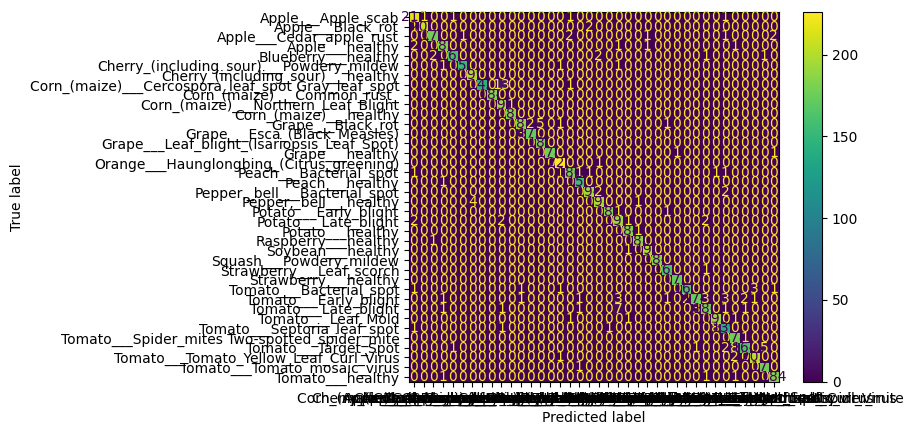

In [16]:
# Load your test dataset
test_ds = test_ds80

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision80_60e = precision_score(labels, predictions, average='micro')
recall80_60e = recall_score(labels, predictions, average='micro')
accuracy80_60e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision80_60e)
print("Recall:", recall80_60e)
print("Accuracy:", accuracy80_60e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [38]:
history_4_80 = model_dep.fit(
    train_ds80,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds80
)

Epoch 1/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0109 - accuracy: 0.9973 - val_loss: 0.1256 - val_accuracy: 0.9733
Epoch 2/20
 922/1757 [==============>...............] - ETA: 19s - loss: 0.0074 - accuracy: 0.9979

KeyboardInterrupt: 

1/1 [==============================] - 0s 24ms/step
Precision: 0.9767804049270848
Recall: 0.9767804049270848
Accuracy: 0.9767804049270848


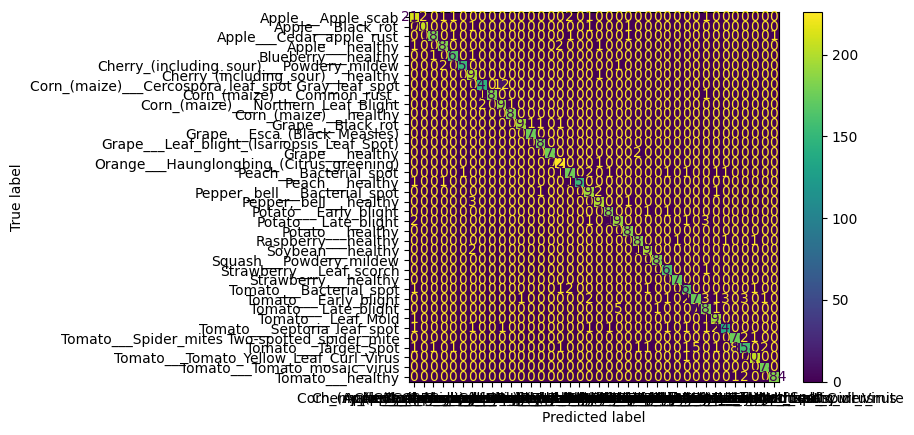

In [18]:
# Load your test dataset
test_ds = test_ds80

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Calculate precision, recall, and accuracy
precision80_80e = precision_score(labels, predictions, average='micro')
recall80_80e = recall_score(labels, predictions, average='micro')
accuracy80_80e = accuracy_score(labels, predictions)

# Display precision, recall, and accuracy
print("Precision:", precision80_80e)
print("Recall:", recall80_80e)
print("Accuracy:", accuracy80_80e)

# Calculate confusion matrix
conf_matrix = confusion_matrix(labels, predictions)

# Display confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
disp.plot()
plt.show()

In [39]:
history_5_80 = model_dep.fit(
    train_ds80,
    epochs=20,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds80
)

Epoch 1/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0110 - accuracy: 0.9969 - val_loss: 0.1636 - val_accuracy: 0.9659
Epoch 2/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0115 - accuracy: 0.9966 - val_loss: 0.1548 - val_accuracy: 0.9668
Epoch 3/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0097 - accuracy: 0.9972 - val_loss: 0.1730 - val_accuracy: 0.9668
Epoch 4/20
1757/1757 [==============================] - 45s 25ms/step - loss: 0.0116 - accuracy: 0.9970 - val_loss: 0.1886 - val_accuracy: 0.9588
Epoch 5/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0104 - accuracy: 0.9970 - val_loss: 0.1206 - val_accuracy: 0.9763
Epoch 6/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0105 - accuracy: 0.9970 - val_loss: 0.1134 - val_accuracy: 0.9759
Epoch 7/20
1757/1757 [==============================] - 44s 25ms/step - loss: 0.0079 - accuracy: 0.9975 - val_loss: 0.1648 -

In [42]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Provided class names
class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

# Initialize lists to store true labels and predictions
labels = []
predictions = []

# Iterate over the test dataset to collect labels and predictions
for images, labels_batch in test_ds:
    predictions_batch = model_dep.predict(images)
    predictions_batch = np.argmax(predictions_batch, axis=1)
    labels.extend(labels_batch.numpy())
    predictions.extend(predictions_batch)

# Generate classification report using provided class names
report = classification_report(labels, predictions, target_names=class_names)

# Display classification report
print("Classification Report:")
print(report)


1/1 [==============================] - 0s 12ms/step
Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       0.97      0.98      0.98       198
                                 Apple___Black_rot       0.99      0.99      0.99       182
                          Apple___Cedar_apple_rust       0.97      0.99      0.98       178
                                   Apple___healthy       0.99      0.96      0.98       191
                               Blueberry___healthy       1.00      0.98      0.99       199
          Cherry_(including_sour)___Powdery_mildew       0.98      0.98      0.98       184
                 Cherry_(including_sour)___healthy       0.99      0.99      0.99       183
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.92      0.93       159
                       Corn_(maize)___Common_rust_       0.99      0.99      0.99       175
    

In [23]:
model_dep.save("./Plant_Model.h5")

In [ ]:
**********************************************

In [2]:
precision40_20e = 0.9472786698877362
precision40_40e = 0.9483207806356876
precision40_60e = 0.9477523565913505
precision40_80e = 0.9469944578655677
precision40_100e = 0.9441997063142438

recall40_20e = 0.9472786698877362
recall40_40e = 0.9483207806356876
recall40_60e = 0.9477523565913505
recall40_80e = 0.9469944578655677
recall40_100e = 0.9441997063142438

accuracy40_20e = 0.9472786698877362
accuracy40_40e = 0.9483207806356876
accuracy40_60e = 0.9477523565913505
accuracy40_80e = 0.9469944578655677
accuracy40_100e = 0.9441997063142438

In [3]:
precision50_20e = 0.9443465408447501
precision50_40e = 0.9549201296117332
precision50_60e = 0.952418850548576
precision50_80e = 0.9405377749985788
precision50_100e = 0.955318060371781

recall50_20e = 0.9443465408447501
recall50_40e = 0.9549201296117332
recall50_60e = 0.952418850548576
recall50_80e = 0.9405377749985788
recall50_100e = 0.955318060371781

accuracy50_20e = 0.9443465408447501
accuracy50_40e = 0.9549201296117332
accuracy50_60e = 0.952418850548576
accuracy50_80e = 0.9405377749985788
accuracy50_100e = 0.955318060371781


In [4]:
precision60_20e = 0.9579987207732216
precision60_40e = 0.9631156278871438
precision60_60e = 0.9688010802359462
precision60_80e = 0.9723544879539479
precision60_100e = 0.9607703787932628

recall60_20e = 0.9579987207732216
recall60_40e = 0.9631156278871438
recall60_60e = 0.9688010802359462
recall60_80e = 0.9723544879539479
recall60_100e = 0.9607703787932628

accuracy60_20e = 0.9579987207732216
accuracy60_40e = 0.9631156278871438
accuracy60_60e = 0.9688010802359462
accuracy60_80e = 0.9723544879539479
accuracy60_100e = 0.9607703787932628

In [5]:
precision70_20e = 0.9707077388264197
precision70_40e = 0.9695738448455069
precision70_60e = 0.9691958801852026
precision70_80e = 0.9708967211565719
precision70_100e = 0.969668336010583

recall70_20e = 0.9707077388264197
recall70_40e = 0.9695738448455069
recall70_60e = 0.9691958801852026
recall70_80e = 0.9708967211565719
recall70_100e = 0.969668336010583

accuracy70_20e = 0.9707077388264197
accuracy70_40e = 0.9695738448455069
accuracy70_60e = 0.9691958801852026
accuracy70_80e = 0.9708967211565719
accuracy70_100e = 0.969668336010583

In [6]:
precision80_20e = 0.9704091745717117
precision80_40e = 0.9733824154042192
precision80_60e = 0.9764972391335127
precision80_80e = 0.9767804049270848
precision80_100e = 0.9780546509981595

recall80_20e = 0.9704091745717117
recall80_40e = 0.9733824154042192
recall80_60e = 0.9764972391335127
recall80_80e = 0.9767804049270848
recall80_100e = 0.9780546509981595

accuracy80_20e = 0.9704091745717117
accuracy80_40e = 0.9733824154042192
accuracy80_60e = 0.9764972391335127
accuracy80_80e = 0.9767804049270848
accuracy80_100e = 0.9780546509981595

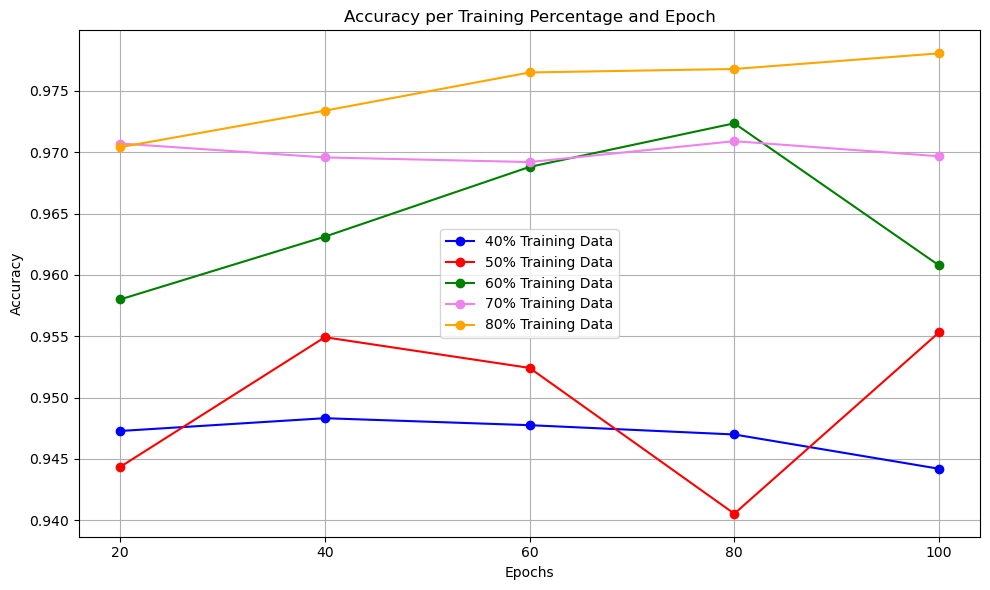

In [7]:
import matplotlib.pyplot as plt

# Accuracy values
accuracy40_20e = 0.9472786698877362
accuracy40_40e = 0.9483207806356876
accuracy40_60e = 0.9477523565913505
accuracy40_80e = 0.9469944578655677
accuracy40_100e = 0.9441997063142438

accuracy50_20e = 0.9443465408447501
accuracy50_40e = 0.9549201296117332
accuracy50_60e = 0.952418850548576
accuracy50_80e = 0.9405377749985788
accuracy50_100e = 0.955318060371781

accuracy60_20e = 0.9579987207732216
accuracy60_40e = 0.9631156278871438
accuracy60_60e = 0.9688010802359462
accuracy60_80e = 0.9723544879539479
accuracy60_100e = 0.9607703787932628

accuracy70_20e = 0.9707077388264197
accuracy70_40e = 0.9695738448455069
accuracy70_60e = 0.9691958801852026
accuracy70_80e = 0.9708967211565719
accuracy70_100e = 0.969668336010583

accuracy80_20e = 0.9704091745717117
accuracy80_40e = 0.9733824154042192
accuracy80_60e = 0.9764972391335127
accuracy80_80e = 0.9767804049270848
accuracy80_100e = 0.9780546509981595

# Extracting accuracy values
acc_40 = [accuracy40_20e, accuracy40_40e, accuracy40_60e, accuracy40_80e, accuracy40_100e]
acc_50 = [accuracy50_20e, accuracy50_40e, accuracy50_60e, accuracy50_80e, accuracy50_100e]
acc_60 = [accuracy60_20e, accuracy60_40e, accuracy60_60e, accuracy60_80e, accuracy60_100e]
acc_70 = [accuracy70_20e, accuracy70_40e, accuracy70_60e, accuracy70_80e, accuracy70_100e]
acc_80 = [accuracy80_20e, accuracy80_40e, accuracy80_60e, accuracy80_80e, accuracy80_100e]

epochs = [20, 40, 60, 80, 100]
training_perc = [40, 50, 60, 70, 80]

# Plotting accuracy
plt.figure(figsize=(10, 6))
plt.plot(epochs, acc_40, label='40% Training Data', color='blue', marker='o')
plt.plot(epochs, acc_50, label='50% Training Data', color='red', marker='o')
plt.plot(epochs, acc_60, label='60% Training Data', color='green', marker='o')
plt.plot(epochs, acc_70, label='70% Training Data', color='violet', marker='o')
plt.plot(epochs, acc_80, label='80% Training Data', color='orange', marker='o')

plt.legend()
plt.title('Accuracy per Training Percentage and Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.xticks(epochs)
plt.grid(True)
plt.tight_layout()
plt.show()


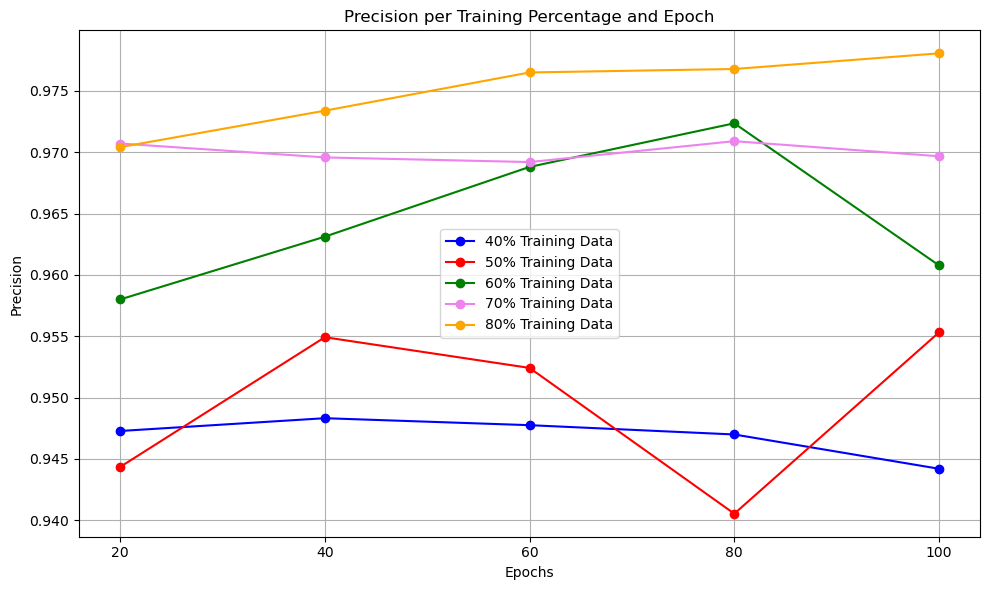

In [8]:
import matplotlib.pyplot as plt

# Precision values
precision40_20e = 0.9472786698877362
precision40_40e = 0.9483207806356876
precision40_60e = 0.9477523565913505
precision40_80e = 0.9469944578655677
precision40_100e = 0.9441997063142438

precision50_20e = 0.9443465408447501
precision50_40e = 0.9549201296117332
precision50_60e = 0.952418850548576
precision50_80e = 0.9405377749985788
precision50_100e = 0.955318060371781

precision60_20e = 0.9579987207732216
precision60_40e = 0.9631156278871438
precision60_60e = 0.9688010802359462
precision60_80e = 0.9723544879539479
precision60_100e = 0.9607703787932628

precision70_20e = 0.9707077388264197
precision70_40e = 0.9695738448455069
precision70_60e = 0.9691958801852026
precision70_80e = 0.9708967211565719
precision70_100e = 0.969668336010583

precision80_20e = 0.9704091745717117
precision80_40e = 0.9733824154042192
precision80_60e = 0.9764972391335127
precision80_80e = 0.9767804049270848
precision80_100e = 0.9780546509981595

# Extracting precision values
prec_40 = [precision40_20e, precision40_40e, precision40_60e, precision40_80e, precision40_100e]
prec_50 = [precision50_20e, precision50_40e, precision50_60e, precision50_80e, precision50_100e]
prec_60 = [precision60_20e, precision60_40e, precision60_60e, precision60_80e, precision60_100e]
prec_70 = [precision70_20e, precision70_40e, precision70_60e, precision70_80e, precision70_100e]
prec_80 = [precision80_20e, precision80_40e, precision80_60e, precision80_80e, precision80_100e]

epochs = [20, 40, 60, 80, 100]
training_perc = [40, 50, 60, 70, 80]

# Plotting precision
plt.figure(figsize=(10, 6))
plt.plot(epochs, prec_40, label='40% Training Data', color='blue', marker='o')
plt.plot(epochs, prec_50, label='50% Training Data', color='red', marker='o')
plt.plot(epochs, prec_60, label='60% Training Data', color='green', marker='o')
plt.plot(epochs, prec_70, label='70% Training Data', color='violet', marker='o')
plt.plot(epochs, prec_80, label='80% Training Data', color='orange', marker='o')

plt.legend()
plt.title('Precision per Training Percentage and Epoch')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.xticks(epochs)
plt.grid(True)
plt.tight_layout()
plt.show()


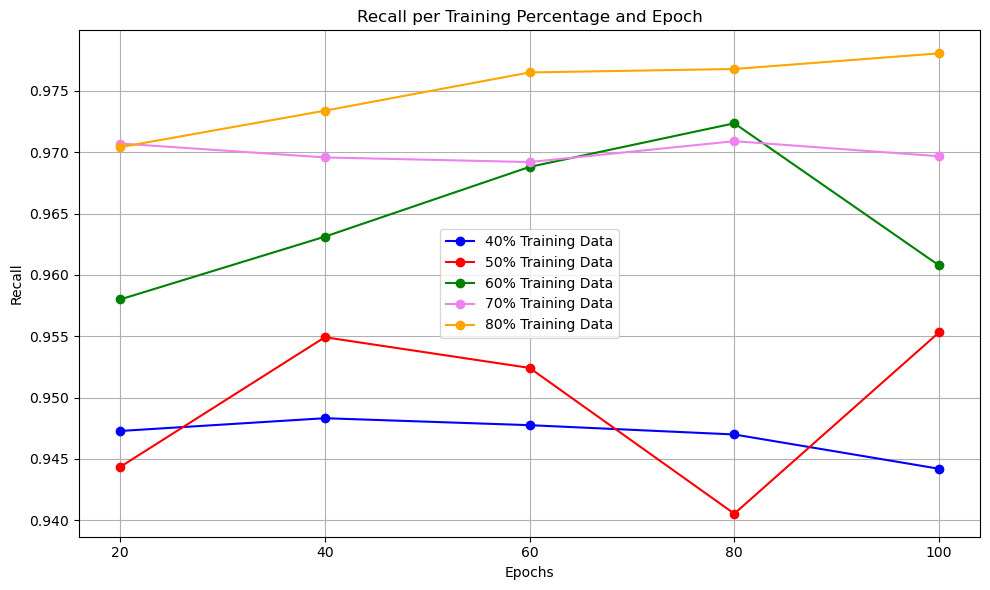

In [9]:
import matplotlib.pyplot as plt

# Recall values
recall40_20e = 0.9472786698877362
recall40_40e = 0.9483207806356876
recall40_60e = 0.9477523565913505
recall40_80e = 0.9469944578655677
recall40_100e = 0.9441997063142438

recall50_20e = 0.9443465408447501
recall50_40e = 0.9549201296117332
recall50_60e = 0.952418850548576
recall50_80e = 0.9405377749985788
recall50_100e = 0.955318060371781

recall60_20e = 0.9579987207732216
recall60_40e = 0.9631156278871438
recall60_60e = 0.9688010802359462
recall60_80e = 0.9723544879539479
recall60_100e = 0.9607703787932628

recall70_20e = 0.9707077388264197
recall70_40e = 0.9695738448455069
recall70_60e = 0.9691958801852026
recall70_80e = 0.9708967211565719
recall70_100e = 0.969668336010583

recall80_20e = 0.9704091745717117
recall80_40e = 0.9733824154042192
recall80_60e = 0.9764972391335127
recall80_80e = 0.9767804049270848
recall80_100e = 0.9780546509981595

# Extracting recall values
recall_40 = [recall40_20e, recall40_40e, recall40_60e, recall40_80e, recall40_100e]
recall_50 = [recall50_20e, recall50_40e, recall50_60e, recall50_80e, recall50_100e]
recall_60 = [recall60_20e, recall60_40e, recall60_60e, recall60_80e, recall60_100e]
recall_70 = [recall70_20e, recall70_40e, recall70_60e, recall70_80e, recall70_100e]
recall_80 = [recall80_20e, recall80_40e, recall80_60e, recall80_80e, recall80_100e]

epochs = [20, 40, 60, 80, 100]
training_perc = [40, 50, 60, 70, 80]

# Plotting recall
plt.figure(figsize=(10, 6))
plt.plot(epochs, recall_40, label='40% Training Data', color='blue', marker='o')
plt.plot(epochs, recall_50, label='50% Training Data', color='red', marker='o')
plt.plot(epochs, recall_60, label='60% Training Data', color='green', marker='o')
plt.plot(epochs, recall_70, label='70% Training Data', color='violet', marker='o')
plt.plot(epochs, recall_80, label='80% Training Data', color='orange', marker='o')

plt.legend()
plt.title('Recall per Training Percentage and Epoch')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.xticks(epochs)
plt.grid(True)
plt.tight_layout()
plt.show()


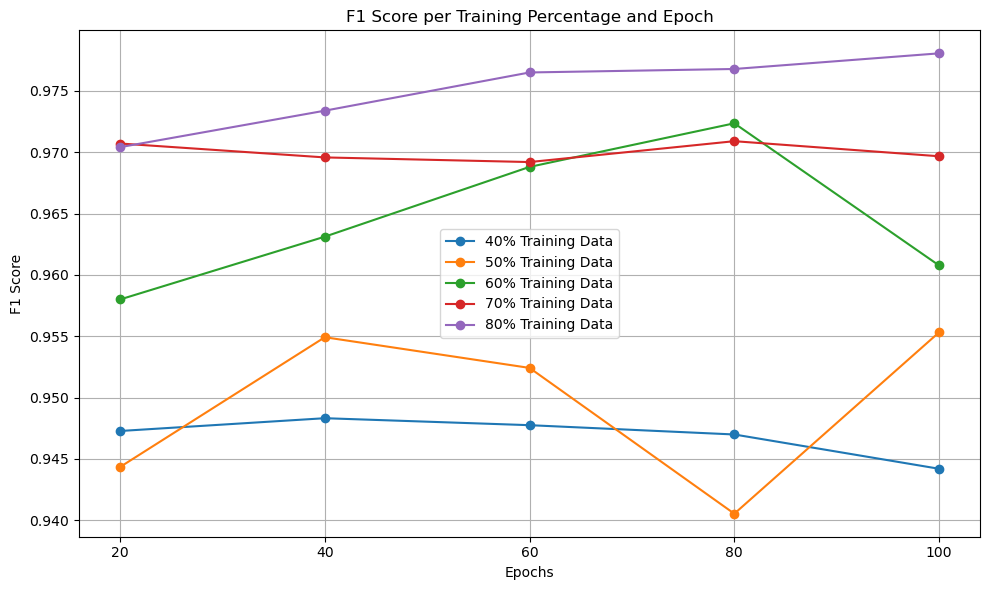

In [13]:
import matplotlib.pyplot as plt

# Precision values
precision_values = {
    "40_20": 0.9472786698877362,
    "40_40": 0.9483207806356876,
    "40_60": 0.9477523565913505,
    "40_80": 0.9469944578655677,
    "40_100": 0.9441997063142438,
    "50_20": 0.9443465408447501,
    "50_40": 0.9549201296117332,
    "50_60": 0.952418850548576,
    "50_80": 0.9405377749985788,
    "50_100": 0.955318060371781,
    "60_20": 0.9579987207732216,
    "60_40": 0.9631156278871438,
    "60_60": 0.9688010802359462,
    "60_80": 0.9723544879539479,
    "60_100": 0.9607703787932628,
    "70_20": 0.9707077388264197,
    "70_40": 0.9695738448455069,
    "70_60": 0.9691958801852026,
    "70_80": 0.9708967211565719,
    "70_100": 0.969668336010583,
    "80_20": 0.9704091745717117,
    "80_40": 0.9733824154042192,
    "80_60": 0.9764972391335127,
    "80_80": 0.9767804049270848,
    "80_100": 0.9780546509981595
}

# Recall values
recall_values = {
    "40_20": 0.9472786698877362,
    "40_40": 0.9483207806356876,
    "40_60": 0.9477523565913505,
    "40_80": 0.9469944578655677,
    "40_100": 0.9441997063142438,
    "50_20": 0.9443465408447501,
    "50_40": 0.9549201296117332,
    "50_60": 0.952418850548576,
    "50_80": 0.9405377749985788,
    "50_100": 0.955318060371781,
    "60_20": 0.9579987207732216,
    "60_40": 0.9631156278871438,
    "60_60": 0.9688010802359462,
    "60_80": 0.9723544879539479,
    "60_100": 0.9607703787932628,
    "70_20": 0.9707077388264197,
    "70_40": 0.9695738448455069,
    "70_60": 0.9691958801852026,
    "70_80": 0.9708967211565719,
    "70_100": 0.969668336010583,
    "80_20": 0.9704091745717117,
    "80_40": 0.9733824154042192,
    "80_60": 0.9764972391335127,
    "80_80": 0.9767804049270848,
    "80_100": 0.9780546509981595
}

# Calculate F1 scores
f1_scores = {}
for key in precision_values:
    precision = precision_values[key]
    recall = recall_values[key]
    f1_scores[key] = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

# Extracting values for plotting
epochs = [20, 40, 60, 80, 100]
training_percentages = [40, 50, 60, 70, 80]
f1_values = [[f1_scores[f"{perc}_{epoch}"] for epoch in epochs] for perc in training_percentages]

# Plotting F1 scores
plt.figure(figsize=(10, 6))
for i, perc in enumerate(training_percentages):
    plt.plot(epochs, f1_values[i], label=f'{perc}% Training Data', marker='o')

plt.legend()
plt.title('F1 Score per Training Percentage and Epoch')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.xticks(epochs)
plt.grid(True)
plt.tight_layout()
plt.show()
